In [1]:
# Fix Conda tensorflow for MAC
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, f1_score
#%matplotlib inline

# Data Loading and Preprocessing

In [3]:
data = pd.read_csv("Churn_Modelling.csv",index_col='RowNumber')

In [4]:
data.columns

Index(['CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age',
       'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'Exited'],
      dtype='object')

In [5]:
# drop unnecessary columns
drop = ['CustomerId', 'Surname']
data.drop(drop, axis=1, inplace=True)
# create dummy for Geography and Gender
Geography = pd.get_dummies(data['Geography'], drop_first=True)
Gender = pd.get_dummies(data['Gender'], drop_first=True)
data.drop(['Geography','Gender'],axis=1,inplace=True)
# new dataframe after encode categorical variables as dummies
data1 = pd.concat([data,Geography,Gender],axis=1)

# Train-Test Split

75% train and 25% test random split

In [6]:
X = data1.drop('Exited', axis=1)
y = data1['Exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)

(7000, 11)
(3000, 11)


In [7]:
y.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

# Feature Selection

crude XGBoost model to select 8 features based on information gain

In [8]:
def feature_selection(xtrain, ytrain, learnRate=0.1, maxDepth=3, numEstimators=100):
    """Function to apply crude xgboost algorithm on training data to select 8 features by gain.
    
    Args:
        xtrain (DataFrame): A DataFrame with features.
        ytrain (Series): A Series with correct class label.
        learnRate (numeric, optional): Boosting learning rate. Default to 0.1.
        maxDepth (numeric, optional): Maximum tree depth for base learners. Default to 3.
        numEstimators (numeric, optional): Number of boosted trees to fit. Default to 100.
    
    Returns:
        xgb (:obj:`xgboost.sklearn.XGBClassifier`): The xgboost classifier.    
        selected_features (str): The features selected from the model.
    
    """
    # initialize the xgboost classifier
    xgb_classifier = xgb.XGBClassifier(objective ='binary:logistic', learning_rate = learnRate,
                                       max_depth = maxDepth, n_estimators = numEstimators)
    
    # fit the classifier on training data
    xgb_classifier.fit(xtrain,ytrain)
    
    # get importance (information gain) for each feature
    importance = xgb_classifier.get_booster().get_score(importance_type='gain')
    # select 8 features with most gain
    selected_features = []
    for value in sorted(importance.values(), reverse=True)[:8]:
        selected_features.append(list(importance.keys())[list(importance.values()).index(value)])
    # print cumulative gain of selected features
    cum_gain = 0
    for feature in selected_features:
        cum_gain += importance[feature]
    print('cumulative gain of selected features is {:.4f}'.format(cum_gain/sum(importance.values())))
    
    return xgb_classifier, selected_features

In [9]:
result = feature_selection(X_train,y_train)
xgb_bin = result[0]
selected_features = result[1]
selected_features

cumulative gain of selected features is 0.9380


['Age',
 'IsActiveMember',
 'NumOfProducts',
 'Germany',
 'Male',
 'Balance',
 'HasCrCard',
 'Tenure']

In [10]:
type(xgb_bin)

xgboost.sklearn.XGBClassifier

# Hyperparameter Tuning

1. XGBoost
2. Random Forest

In [10]:
def xgboost_tuning(xtrain, ytrain, n_estimators, learning_rate, max_depth, selected_features):
    """Function to run xgboost grid search algorithm on training data to select best tuning parameters.
    
    Args:
        xtrain (DataFrame): A DataFrame with features.
        ytrain (Series): A Series with correct class label.
        num_estimators (list): Number of boosted trees to fit.
        learning_rate (list): Boosting learning rates.
        max_depth (list): Maximum tree depths for base learners.
        selected_features (list): A list of selected features to train the model on.
    
    Returns:
        clf.best_estimator_ (:obj:`xgboost.sklearn.XGBClassifier`): The best xgboost classifier.
    
    """
    # initialize xgboost classifier
    xgb_model = xgb.XGBClassifier()
    # prepare parameters for grid search
    param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth)
    # run grid search with different combinations of parameters
    clf = GridSearchCV(xgb_model, param_grid, n_jobs=5, 
                       cv=StratifiedKFold(n_splits=5, shuffle=True), 
                       scoring='roc_auc',
                       verbose=2, refit=True)
    # fit model on training data
    clf.fit(xtrain[selected_features], ytrain)
    # return model with best combination of parameters
    return clf.best_estimator_

In [13]:
n_estimators = [50, 100, 200, 300]
learning_rate = [0.001, 0.01, 0.05, 0.1]
max_depth = [3, 4, 5, 6]
xgb_model = xgboost_tuning(X_train, y_train, n_estimators, learning_rate, max_depth, selected_features)
xgb_model

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   16.1s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:  1.3min
[Parallel(n_jobs=5)]: Done 320 out of 320 | elapsed:  2.8min finished


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [14]:
xgb_model = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [11]:
def random_forest_tuning(xtrain, ytrain, n_estimators, max_depth, max_features, selected_features):
    """Function to run random forest grid search algorithm on training data to select best tuning parameters.
    
    Args:
        xtrain (DataFrame): A DataFrame with features.
        ytrain (Series): A Series with correct class label.
        num_estimators (list): Number of trees in the forest.
        max_depth (list): Maximum tree depths for base learners.
        max_features (list): Max number of features considered for splitting a node.
        selected_features (list): A list of selected features to train the model on.
    
    Returns:
        rf_cv.best_estimator_ (:obj:`RandomForestClassifier`): The best random forest classifier.
    
    """
    # initialize xgboost classifier
    rf = RandomForestClassifier()
    # prepare parameters for grid search
    param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features)
    # run grid search with different combinations of parameters
    rf_cv = GridSearchCV(rf, param_grid, n_jobs=5, 
                         cv=StratifiedKFold(n_splits=5, shuffle=True), 
                         scoring='roc_auc',
                         verbose=2, refit=True)
    # fit model on training data
    rf_cv.fit(xtrain[selected_features], ytrain)
    # return model with best combination of parameters
    return rf_cv.best_estimator_

In [12]:
n_estimators = [50, 100, 200, 300]
max_depth = [3, 4, 5, 6]
max_features = [3, 4, 5, 6]
rf = random_forest_tuning(X_train, y_train, n_estimators, max_depth, max_features, selected_features)
rf

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    8.7s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:   39.9s
[Parallel(n_jobs=5)]: Done 320 out of 320 | elapsed:  1.9min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features=4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [10]:
rf = RandomForestClassifier(max_depth=6, max_features=4,n_estimators=300)
rf.fit(X_train[selected_features],y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features=4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

# Model Comparison

Compare AUC and F1 scores across
1. Logistic Regression
2. Random Forest
3. XGBoost

In [29]:
# Logistic Regression Model Training
def logit(xtrain, ytrain, selected_features):
    """Function to run logistic regression algorithm on training data.
    
    Args:
        xtrain (DataFrame): A DataFrame with features.
        ytrain (Series): A Series with correct class label.
        selected_features (list): A list of selected features to train the model on.
    
    Returns:
        logmodel (:obj:`LogisticRegression`): The best xgboost classifier.
    
    """
    logmodel = LogisticRegression()
    logmodel.fit(X_train[selected_features],y_train)
    return logmodel

In [30]:
logmodel = logit(X_train, y_train, selected_features)
logmodel

/Users/tianfu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [13]:
def evaluate(model, test_features, test_labels):
    """Function to evaluate model performance on test data.
    
    Args:
        model (:obj: model trained): Classification model trained.
        test_features (DataFrame): A DataFrame as test set with selected features.
        test_labels (Series): A Series with correct class label for test set.
    
    """
    # prediction results on test set
    predictions = model.predict(test_features)

    print('################### Model Performance ###################')
    print("F1-score: " + str(f1_score(y_test, predictions)))
    print("AUC: " + str(roc_auc_score(y_test, predictions)))
    print()
    print('################### Confusion Matrix ###################')
    print(confusion_matrix(test_labels, predictions))
    

In [39]:
evaluate(logmodel, X_test[selected_features], y_test)

################### Model Performance ###################
F1-score: 0.0
AUC: 0.5

################### Confusion Matrix ###################
[[2416    0]
 [ 584    0]]


/Users/tianfu/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [14]:
evaluate(rf, X_test[selected_features], y_test)

################### Model Performance ###################
F1-score: 0.5770491803278688
AUC: 0.712161503220539

################### Confusion Matrix ###################
[[2349   67]
 [ 320  264]]


In [25]:
evaluate(xgb_model, X_test[selected_features], y_test)

################### Model Performance ###################
F1-score: 0.598941798941799
AUC: 0.726152136441985

################### Confusion Matrix ###################
[[2338   78]
 [ 301  283]]


In [57]:
def predicted_prob(model, xtest, selected_features):
    """Function to generate predicted class probabilities for test data.
    
    Args:
        model (:obj: model trained): Classification model trained.
        xtest (Series): A DataFrame as test set with features.
        selected_features (list): A list of selected features on which the model was trained.
    
    Returns:
        churn_probs (numpy.ndarray): Predicted probability of churn for each observation in test.
    
    """
    probs = model.predict_proba(xtest[selected_features])
    churn_probs = probs[:,1]
    return churn_probs

In [59]:
logmodel_probs = predicted_prob(logmodel, X_test, selected_features)
logmodel_probs
#print(logmodel_probs.shape)

array([0.29073487, 0.24275398, 0.21948375, ..., 0.25452591, 0.29221372,
       0.2868338 ])

In [60]:
rf_probs = predicted_prob(rf, X_test, selected_features)
rf_probs

array([0.04316376, 0.06209654, 0.11456036, ..., 0.10320802, 0.01957687,
       0.24430829])

In [61]:
xgb_probs = predicted_prob(xgb_model, X_test, selected_features)
xgb_probs

array([0.04434106, 0.03925258, 0.08520908, ..., 0.05524413, 0.01158028,
       0.36693183], dtype=float32)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a248417f0>]],
      dtype=object)

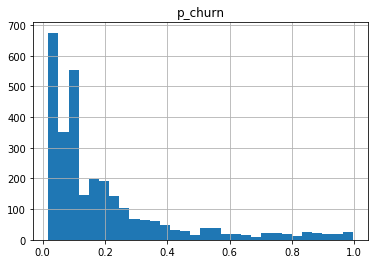

In [80]:
pd.DataFrame(rf_probs.tolist(),columns=['p_churn']).hist(bins=30)

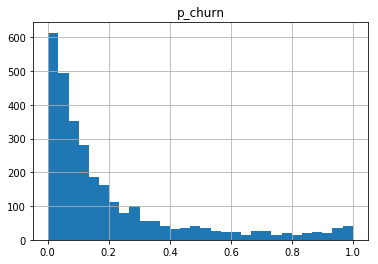

In [79]:
pd.DataFrame(xgb_probs.tolist(),columns=['p_churn']).hist(bins=30)
plt.x_label = 'predicted probability of churn'
plt.y_label = 'count'

# User Input

In [ ]:
def user_features_input(Age,IsActiveMember,NumOfProducts,Germany,Gender,Balance,HasCrCard,Tenure):
    """Function to handle user inputs of features.
    
    Args:
        Age (str): Age of the customer.
        IsActiveMember (str): Whether or not the customer is an active member.
        NumOfProducts (str): Number of bank products the customer is using.
        Germany (str): Whether or not the customer is a German customer.
        Gender (str): Gender of the customer.
        Balance (str): Balance left on customer's account.
        HasCrCard (str): Whether or not the customer has a credit card.
        Tenure (str): How long the customer has been with the bank.
        
    Returns:
        inputs (list): A list of input features.
    
    """
    # valid inputs for binary variables
    valid_binary = ["0","1"]
    
    inputs = []
    
    # Age - int
    try:
        age = int(Age)
        if age >= 0 and age <= 110:
            inputs.append(age)
        else:
            return 'Invalid input for Age, must be an integer between 0 and 110!'
    except:
        return 'Please input a numeric value!'
    
    # IsActiveMember - binary
    try:
        if IsActiveMember in valid_binary:
            inputs.append(int(IsActiveMember))
        else:
            return 'Invalid input for IsActiveMember, must be either 0 or 1!'
    except:
        return 'Please input a numeric value, either 0 or 1!'
    
    # NumOfProducts - int
    try:
        numofproducts = int(NumOfProducts)
        if numofproducts >= 0:
            inputs.append(numofproducts)
        else:
            return 'Invalid input for NumOfProducts, must be an integer greater than 0!'
    except:
        return 'Please input a numeric value!'
    
    # Germany - binary
    try:
        if Germany in valid_binary:
            inputs.append(int(Germany))
        else:
            return 'Invalid input for Germany, must be either 0 or 1!'
    except:
        return 'Please input a numeric value, either 0 or 1!'
    
    # Gender - binary - Male is 1
    try:
        if Gender in valid_binary:
            inputs.append(int(Gender))
        else:
            return 'Invalid input for Gender, must be either 0 or 1!'
    except:
        return 'Please input your gender!'
    
    # Balance - float
    try:
        balance = float(Balance)
        if balance >= 0:
            inputs.append(balance)
        else:
            return 'Invalid input for balance, must be nonnegative!'
    except:
        return 'Please input a numeric value!'
    
    # HasCrCard - binary
    try:
        if HasCrCard in valid_binary:
            inputs.append(int(HasCrCard))
        else:
            return 'Invalid input for HasCrCard, must be either 0 or 1!'
    except:
        return 'Please input a numeric value, either 0 or 1!'
    
    # Tenure - int
    try:
        tenure = int(Tenure)
        if tenure >= 0:
            inputs.append(tenure)
        else:
            return 'Invalid input for Tenure, must be an integer greater than 0!'
    except:
        return 'Please input a numeric value!'
    
    return inputs
    